<h1><center>Machine Learning Project - AVAZU<center></h1>


In [1]:
import sys
from zipfile import ZipFile
import os.path as op
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve
    
AVAZU_URL = "https://bianchi.wp.imt.fr/files/2019/05/train-1000000.zip"
AVAZU_FILENAME = AVAZU_URL.rsplit('/', 1)[1]


if not op.exists(AVAZU_FILENAME):
    print('Downloading %s to %s...' % (AVAZU_URL, AVAZU_FILENAME))
    urlretrieve(AVAZU_URL, AVAZU_FILENAME)
    ZipFile(AVAZU_FILENAME).extractall('.')

In [2]:
ZipFile(AVAZU_FILENAME).extractall('.')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import xgboost as xgb
%matplotlib inline

Data description here: https://www.kaggle.com/c/avazu-ctr-prediction/data  


In [4]:
data = pd.read_csv('train-1000000')
Y = data['click']
X = data.drop(columns=['click'])

In [5]:
data.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,3.983206e+18,0,14102915,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,2,4687,320,50,423,2,39,100148,32
1,7.756884e+18,0,14103007,1002,0,cb809abf,74acf31a,50e219e0,ecad2386,7801e8d9,...,0,0,17894,320,50,2039,2,39,100077,32
2,6.941774e+17,0,14102711,1005,0,85f751fd,c4e18dd6,50e219e0,e9739828,df32afa9,...,1,0,22684,320,50,2619,1,163,100055,71
3,2.664154e+18,1,14102903,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,...,1,0,23222,320,50,2676,0,35,100176,221
4,1.480510e+19,0,14102902,1005,1,791b5571,fd13bc73,f028772b,ecad2386,7801e8d9,...,1,0,8330,320,50,761,3,175,100081,23


In [6]:
data.nunique()

id                  1000000
click                     2
hour                    240
C1                        7
banner_pos                7
site_id                2651
site_domain            2871
site_category            22
app_id                 3157
app_domain              198
app_category             26
device_id            150501
device_ip            555248
device_model           5168
device_type               5
device_conn_type          4
C14                    2243
C15                       8
C16                       9
C17                     420
C18                       4
C19                      66
C20                     163
C21                      60
dtype: int64

Check if there are any Null Values

In [7]:
data.isnull().any().any()

False

# Dropping ID and Encoding hour column
We can see that ID is unique so we can just drop that column.</br>

From the 'hour' column (YYMMDDHH), only hour and weekday seems relevant to evaluate clicks we only extract those values.</br>However, this has an issue that although hour 0 and hour 23 is very close, they are assessed differently numerically.</br>So realizing this cyclic nature, we use sin for encoding.

In [8]:
import datetime
def datesplit(originalDate):
    originalDate = str(originalDate)
    
    year = int("20" + originalDate[0:2])
    month = int(originalDate[2:4])
    day = int(originalDate[4:6])
    hour = int(originalDate[6:8])
    
    return datetime.datetime(year, month, day, hour)

# Extract and encode hour
X['hour_sin'] = X['hour'].apply(lambda x: np.sin(2 * np.pi * datesplit(x).hour / 24))
# Extract and encode weekday
X['weekday_sin'] = X['hour'].apply(lambda x: np.sin(2 * np.pi * datesplit(x).weekday() / 7))
# Drop original hour column
X = X.drop(columns=['hour'])
X = X.drop(columns=['id'])
X

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,...,C14,C15,C16,C17,C18,C19,C20,C21,hour_sin,weekday_sin
0,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,fb6566d3,...,4687,320,50,423,2,39,100148,32,-0.707107,0.974928
1,1002,0,cb809abf,74acf31a,50e219e0,ecad2386,7801e8d9,07d7df22,9b7af851,ac5a4a77,...,17894,320,50,2039,2,39,100077,32,0.965926,0.433884
2,1005,0,85f751fd,c4e18dd6,50e219e0,e9739828,df32afa9,cef3e649,a99f214a,748e298a,...,22684,320,50,2619,1,163,100055,71,0.258819,0.000000
3,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,0f2161f8,a99f214a,a50da3d4,...,23222,320,50,2676,0,35,100176,221,0.707107,0.974928
4,1005,1,791b5571,fd13bc73,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,d5f88679,...,8330,320,50,761,3,175,100081,23,0.500000,0.974928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1005,0,5b08c53b,7687a86e,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,9a8dbe7f,...,19016,300,250,2162,2,39,-1,33,0.500000,-0.781831
999996,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,3b6f9f67,...,15701,320,50,1722,0,35,-1,79,0.258819,0.781831
999997,1005,1,f61eaaae,6b59f079,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,2348915f,...,16615,320,50,1863,3,39,-1,23,-1.000000,0.433884
999998,1005,1,57ef2c87,bd6d812f,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,3ca7f719,...,19772,320,50,2227,0,935,-1,48,0.866025,0.974928


# Splitting the data into test and train sets.

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Concatenating the X and Y in training since we need it for target encoding later on
df = pd.concat([X_train, y_train], axis=1)
df.head()

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,...,C15,C16,C17,C18,C19,C20,C21,hour_sin,weekday_sin,click
566853,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,9eed8f82,...,320,50,1974,2,39,100021,33,0.258819,0.433884,1
382311,1005,0,85f751fd,c4e18dd6,50e219e0,03528b27,2347f47a,8ded1f7a,a99f214a,f84a5465,...,320,50,1722,0,35,-1,79,0.866025,0.781831,0
241519,1005,0,6399eda6,968765cd,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,384ad9d3,...,320,50,1800,3,167,100077,23,-0.965926,0.000000,0
719220,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,5185f942,...,320,50,1722,0,35,100084,79,0.500000,-0.781831,0
905718,1005,0,85f751fd,c4e18dd6,50e219e0,e2fcccd2,5c5a694b,0f2161f8,a99f214a,dffc1350,...,320,50,2201,3,35,-1,43,0.707107,0.781831,0


In [10]:
df.describe()

,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,hour_sin,weekday_sin,click
count,800000.00000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,8.000000e+05,800000.000000,800000.000000
mean,1004.96863,0.288654,1.015581,0.332185,18833.304137,318.884985,60.054878,2111.578251,1.433700,227.112131,53172.284667,83.415882,4.299594e-02,0.299024,0.170061
std,1.09501,0.506066,0.527756,0.855622,4969.807015,21.309369,47.238354,610.720350,1.325692,351.077636,49959.684491,70.360059,7.199218e-01,0.677229,0.375687
min,1001.00000,0.000000,0.000000,0.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,-1.000000,1.000000,-1.000000e+00,-0.974928,0.000000
25%,1005.00000,0.000000,1.000000,0.000000,16920.000000,320.000000,50.000000,1863.000000,0.000000,35.000000,-1.000000,23.000000,-7.071068e-01,-0.433884,0.000000
50%,1005.00000,0.000000,1.000000,0.000000,20346.000000,320.000000,50.000000,2323.000000,2.000000,39.000000,100048.000000,61.000000,1.224647e-16,0.433884,0.000000
75%,1005.00000,1.000000,1.000000,0.000000,21894.000000,320.000000,50.000000,2526.000000,3.000000,171.000000,100088.000000,101.000000,7.071068e-01,0.781831,0.000000
max,1012.00000,7.000000,5.000000,5.000000,24043.000000,1024.000000,1024.000000,2757.000000,3.000000,1839.000000,100248.000000,255.000000,1.000000e+00,0.974928,1.000000


The main thing to notice here is that our target 'Click' has mean of 0.17 i.e. only 17 percent are 1s and the rest are all 0s. So we have a heavily imbalanced dataset. What this means is that accuracy is not a good metric of performance (which we will see later). This is visually represented in the plot below as well.

Text(0.5, 1.0, 'Click Distribution (Class Balance)')

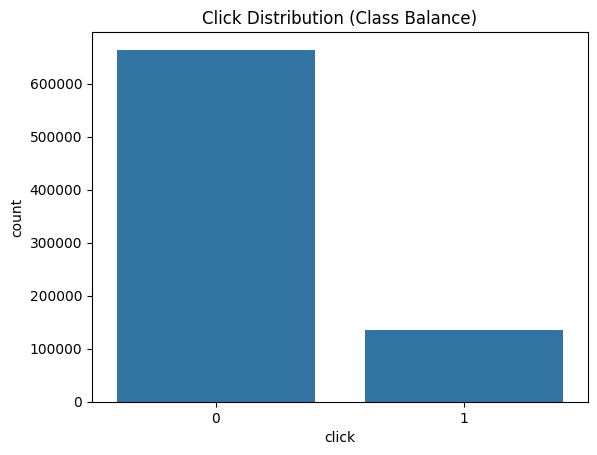

In [11]:
sns.countplot(x='click', data=df)
plt.title('Click Distribution (Class Balance)')

In [12]:
df.nunique()

C1                       7
banner_pos               7
site_id               2529
site_domain           2693
site_category           22
app_id                2898
app_domain             184
app_category            26
device_id           122738
device_ip           463036
device_model          4989
device_type              4
device_conn_type         4
C14                   2194
C15                      8
C16                      9
C17                    418
C18                      4
C19                     66
C20                    163
C21                     60
hour_sin                21
weekday_sin              7
click                    2
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800000 entries, 566853 to 121958
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   C1                800000 non-null  int64  
 1   banner_pos        800000 non-null  int64  
 2   site_id           800000 non-null  object 
 3   site_domain       800000 non-null  object 
 4   site_category     800000 non-null  object 
 5   app_id            800000 non-null  object 
 6   app_domain        800000 non-null  object 
 7   app_category      800000 non-null  object 
 8   device_id         800000 non-null  object 
 9   device_ip         800000 non-null  object 
 10  device_model      800000 non-null  object 
 11  device_type       800000 non-null  int64  
 12  device_conn_type  800000 non-null  int64  
 13  C14               800000 non-null  int64  
 14  C15               800000 non-null  int64  
 15  C16               800000 non-null  int64  
 16  C17               80

Banner_pos represents the position of where the ad is displayed. Intuitively thinking, this should have a huge effect on CTR. So, let's analyse it to confirm our hypothesis.

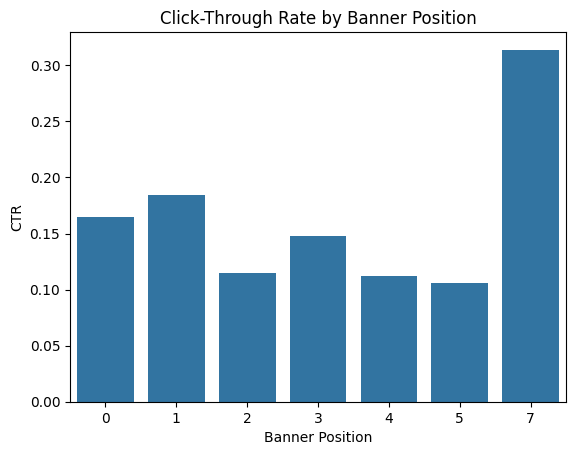

In [14]:
ctr_by_banner = df.groupby('banner_pos')['click'].mean().reset_index()

sns.barplot(data=ctr_by_banner, x='banner_pos', y='click')
plt.title('Click-Through Rate by Banner Position')
plt.ylabel('CTR')
plt.xlabel('Banner Position')
plt.show()

As anticipated, banner position 7 has a relatively higher CTR which could indicate something like it is placed in a spot often likely to be misclicked. This variation shows that banner_pos might carry strong predictive signal. 

Lets take columns that have low cardinality, making them ideal for grouped analysis and direct interpretation of click rate patterns.

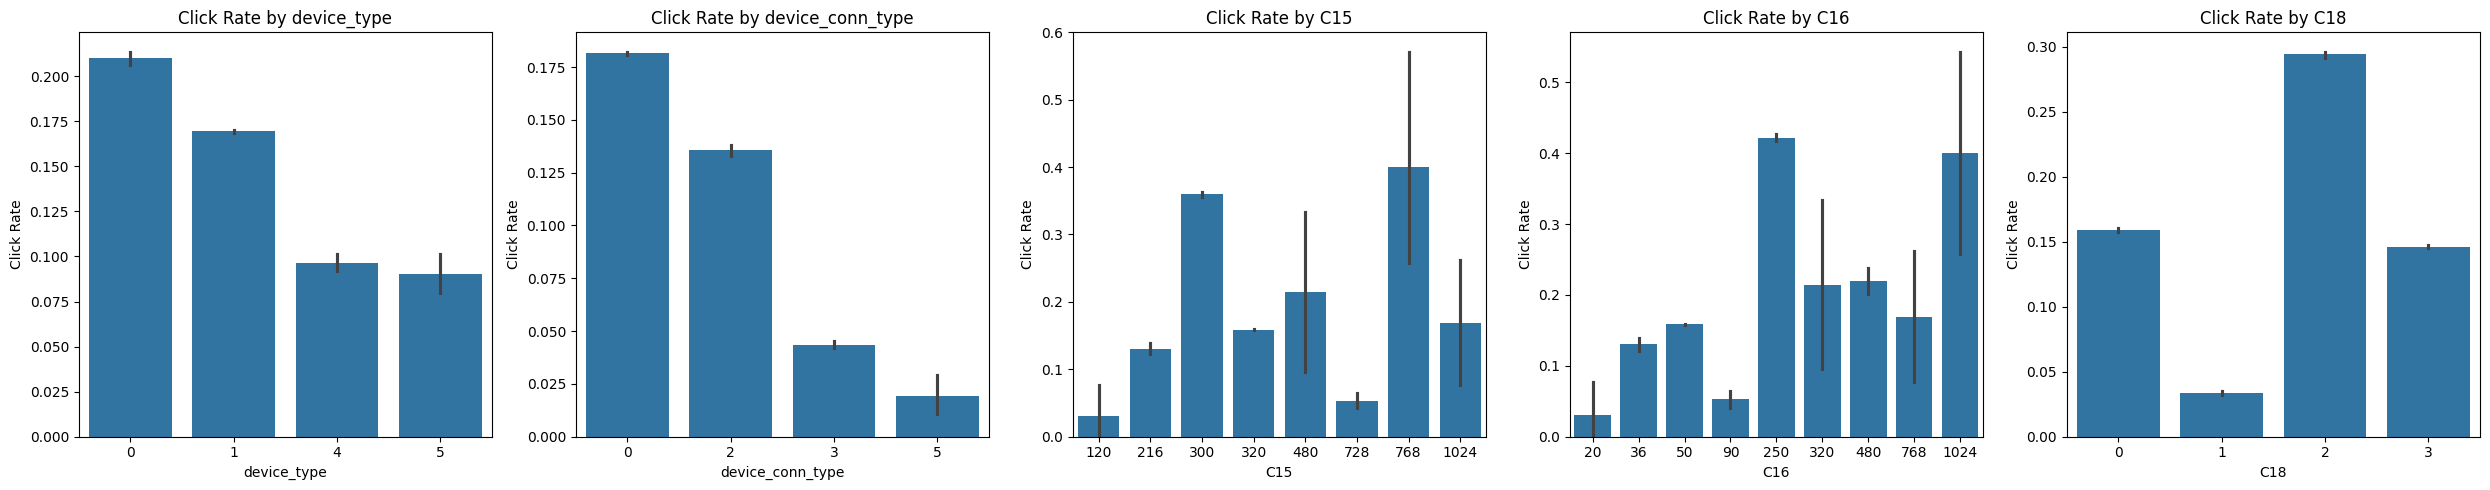

In [15]:
cols = ['device_type', 'device_conn_type', 'C15', 'C16', 'C18']

# Create subplots (adjust cols and rows based on how many plots you want)
fig, axes = plt.subplots(1, len(cols), figsize=(5 * len(cols), 5))  # 1 row, 5 columns

# Iterate and plot on each subplot
for i, col in enumerate(cols):
    sns.barplot(x=col, y='click', data=df, ax=axes[i])
    axes[i].set_title(f'Click Rate by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Click Rate')

plt.tight_layout()
plt.show()

Click rates vary significantly across categories — especially for device_type=0 and device_conn_type=0, which show higher engagement.

Among all categories, there are some very noticable categories that have high and low CTR.

These features are likely good predictors and could be useful for simple rules or categorical encoding.

Lets analyse C21 since it has a mid-range cardinality. So we can't say for sure if it is purely categorical nor fully numerical, making it a gray-area feature — which often benefits from class-wise histograms to reveal hidden structure.

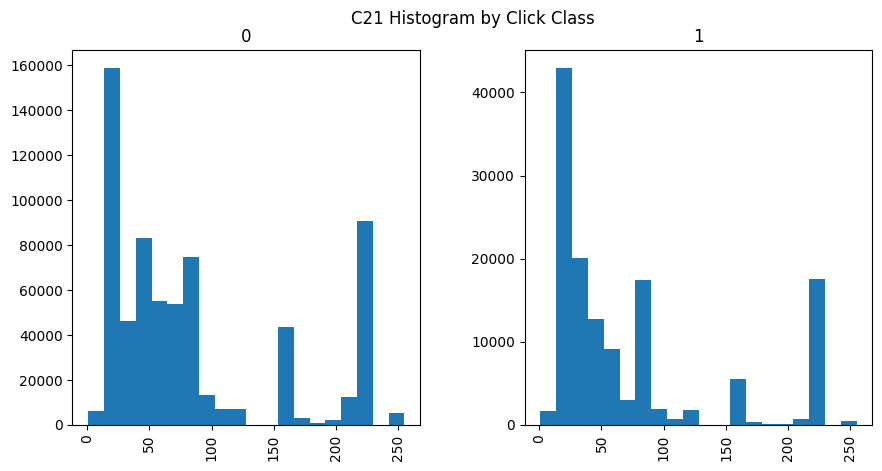

In [16]:
df['click_str'] = df['click'].astype(str)
df[['C21', 'click_str']].hist(by='click_str', bins=20, figsize=(10, 5), sharex=True)
plt.suptitle('C21 Histogram by Click Class')
df = df.drop(columns='click_str')

The distribution of C21 differs notably between click classes. For both clicked (1) and non-clicked (0), values are heavily concentrated around certain bins (e.g., ~20–30, ~80, ~220), but the frequency and relative prominence of these bins vary across classes. This suggests that some C21 values may be more predictive of a click than others — making it a potentially useful feature for modeling despite being mid-cardinality.

Lets take columns that have high cardinality (hundreds or thousands of unique values), making them hard to group, so boxplots are used to visualize distribution differences.

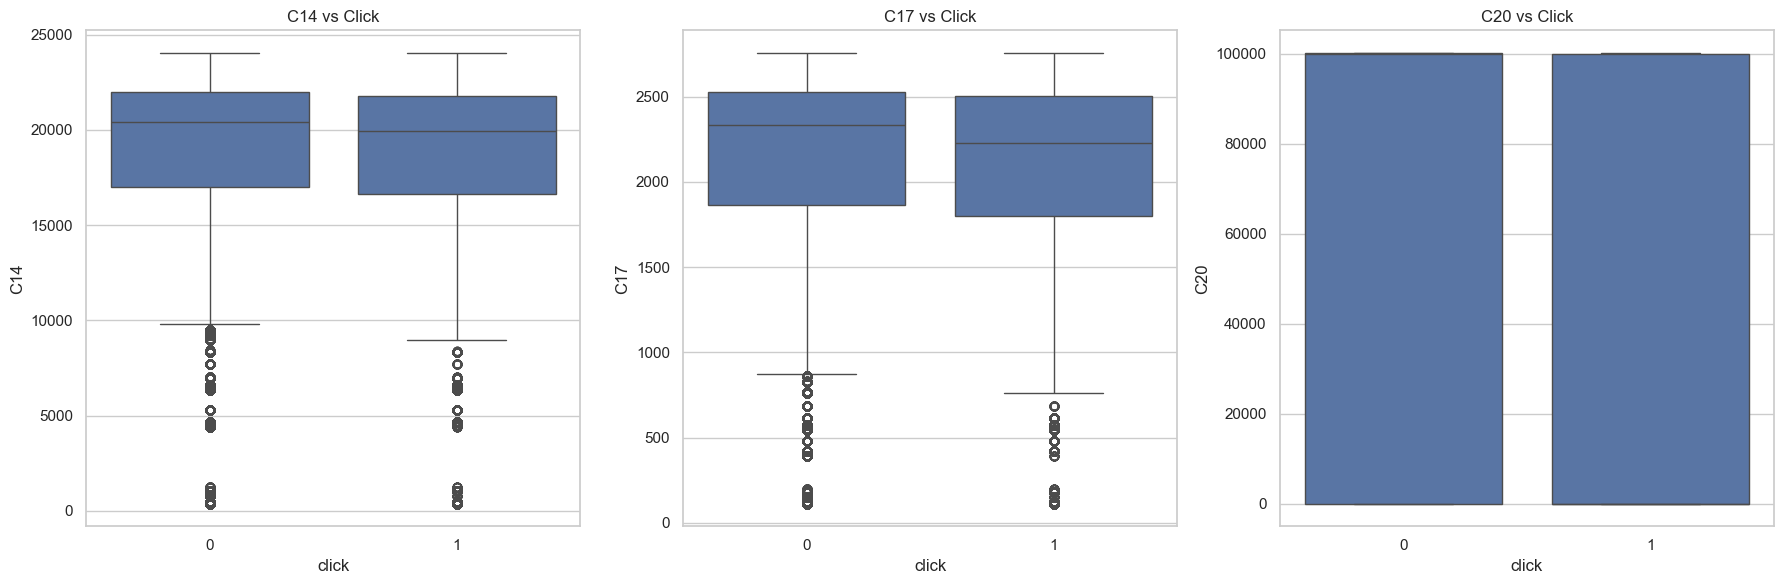

In [17]:
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot 1: C14 vs click
sns.boxplot(x='click', y='C14', data=df, ax=axes[0])
axes[0].set_title('C14 vs Click')

# Boxplot 2: C17 vs click
sns.boxplot(x='click', y='C17', data=df, ax=axes[1])
axes[1].set_title('C17 vs Click')

# Boxplot 3: C20 vs click
sns.boxplot(x='click', y='C20', data=df, ax=axes[2])
axes[2].set_title('C20 vs Click')

# Adjust layout
plt.tight_layout()
plt.show()

C14 and C17 show nearly identical distributions across click labels → likely weak standalone predictors.

C20 shows no visible difference between click=0 and click=1 → potentially not useful for prediction without transformation.

These features might need further preprocessing (e.g. embeddings) or could serve better in feature interactions.

# Setting up some helper functions

no_cat_data function removes all the columns of datatype object.</br>

In [18]:
def no_cat_data(df):
    return df.select_dtypes(exclude=['object', 'category'])

all_ohe_traindata takes dataframe and col_list as parameter and one hot encodes the columns in col_list and then returns the dataframe and a dictionary that stores the columns along with the encoded categories. This is done in training dataset.

all_ohe_testdata takes that dictionary and dataframe as parameters and applies the same one hot encoding done in traindata and returns the edited dataframe. It ignores new categories and adds a columns of 0s even if a category does not exist for some column. This is done in testing dataset.

In [19]:
def all_ohe_traindata(df, col_list):
    ohe_categories = {}  # To track unique categories for each column
    
    # Filter out columns that are in col_list
    cat_cols = [col for col in col_list if col in df.columns]
    
    for col in cat_cols:
        # Track unique categories for each column
        categories = df[col].unique().tolist()
        ohe_categories[col] = categories
        
        # Create one-hot encoded columns
        ports = pd.get_dummies(df[col], prefix=col, prefix_sep='_')
        ports = ports.astype(int)
        # Drop the original column and concatenate the one-hot encoded columns
        df = pd.concat([df.drop(columns=[col]), ports], axis=1)
    
    return df, ohe_categories

def all_ohe_testdata(df, ohe_categories, col_list):
    # Keep original test data columns
    encoded_df = df.copy() 
    
    for col, categories in ohe_categories.items():
        if col in col_list:
            # For each category in training data, create a column in the test data
            for cat in categories:
                new_col = f"{col}_{cat}"
                
                if col in df:
                    # If the column exists in the test data, set 1 where the category occurs, else 0
                    encoded_df[new_col] = (df[col] == cat).astype(int)
                else:
                    # If the column does not exist in the test data, create the column with all 0s
                    encoded_df[new_col] = 0  # Set all to 0 as the category doesn't exist in the test set
    encoded_df = encoded_df.drop(columns=col_list, errors='ignore')
    return encoded_df


all_target_traindata takes dataframe and col_list as parameter and applies target encoding i.e. takes the mean of the category w.r.t. the frequency of clicks and gives all the respective categories that value. The function then returns the edited dataframe as well as a dictionary that tracks the columns and categories with the values assigned. This is done in train set.</br>

all_target_testdata takes the dictonary as parameter and applies the same target encoding as in traindata. For new categories that may arise, it assigns the overall mean of click. This is done in test set.

In [20]:
def all_target_traindata(df, col_list):
    df = df.copy()
    target_dict = {}
    
    # Filter the columns to only include those in col_list
    cat_cols = col_list
    
    # Loop over each categorical column specified in col_list
    for col in cat_cols:
        # Calculate the mean of the target ('click') for each category in the column
        target_mean = df.groupby(col)['click'].mean().to_dict()
        target_dict[col] = target_mean
        
        df[col] = df[col].map(target_mean)
    
    return df, target_dict
    
def all_target_testdata(df, target_dict, col_list, overall_mean):
    df = df.copy()
    
    # Filter the columns to only include those in col_list
    cat_cols = col_list
    
    # Loop over each categorical column specified in col_list
    for col in cat_cols:
        if col in target_dict:
            target_mean = target_dict[col]  # Get target means for this column
            
            # Replace each category in the column with the corresponding target mean
            df[col] = df[col].map(target_mean)
            
            # Handle categories in the test data that are not seen in the training data
            # Replace missing categories with the overall mean of the 'click' column
            df[col] = df[col].fillna(overall_mean)  # Directly reassign the result to df[col]
    
    return df


# Approach 0 : Just Guess 0

Lets make a model that just guesses 0 and see what happens

In [21]:
from sklearn.metrics import accuracy_score, log_loss

y_pred_zeros = [0] * len(y_test)  # Create a column of zeros with the same length as y_test

# Predicted probabilities (for Log Loss calculation)
# In the case of zero predictions, the probability for the positive class is 0.
y_pred_zeros_prob = [0.0] * len(y_test)  # Probabilities for class 1 being 0

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_zeros)
print(f"Accuracy: {accuracy:.4f}")

# Calculate Log Loss
log_loss_score = log_loss(y_test, y_pred_zeros_prob)
print(f"Log Loss: {log_loss_score:.4f}")

Accuracy: 0.8304
Log Loss: 6.1134


We can see that we get an accuracy of 83 percent but remember that our data is heavily imbalanced. So although this looks good on paper, accuracy is not a good metric. So instead, we will mainly use the metric of <b>log loss</b> to evaluate the performance of different models and also have a look at Precision, Recall, F1 score, Confusion Matrix and AUC and ROC curve for metrics.

# Evaluation Metrics for Imbalanced Data

### 1. **Log Loss (Logarithmic Loss)**
   - **Description**: Log loss measures the uncertainty of the model's predictions based on how far off they are from the true labels. It penalizes wrong predictions that are confident, making it sensitive to the model's confidence in its predictions. For imbalanced datasets, log loss is valuable because it accounts for the misclassification of the minority class, which can be easily overlooked by other metrics like accuracy.

### 2. **Precision**
   - **Description**: Precision is the ratio of correctly predicted positive observations to the total predicted positives. It is useful when you want to minimize false positives. In imbalanced data, it ensures that when the model predicts the minority class (typically the positive class), it is accurate. High precision means the model doesn’t falsely predict the minority class too often.

### 3. **Recall**
   - **Description**: Recall is the ratio of correctly predicted positive observations to all observations in actual class. It helps you capture all the actual positive cases, which is crucial in imbalanced datasets. In cases where missing out on predicting the minority class is costly (e.g., fraud detection or medical diagnoses), recall ensures that as many of the true positive instances as possible are identified.

### 4. **F1 Score**
   - **Description**: The F1 score is the harmonic mean of precision and recall. It balances the trade-off between the two, making it particularly useful in imbalanced data. It helps ensure that the model is not biased towards the majority class and provides a single metric that combines both precision and recall into a meaningful score.

### 5. **Confusion Matrix**
   - **Description**: The confusion matrix is a table that shows the actual vs predicted classifications, with true positives, true negatives, false positives, and false negatives. This is especially useful for imbalanced datasets as it provides detailed insight into the model's performance, highlighting how many errors (false positives and false negatives) are made. It's helpful for identifying patterns of misclassification, particularly for the minority class.

### 6. **AUC (Area Under the Curve)**
   - **Description**: AUC measures the area under the ROC curve. It represents the model's ability to distinguish between positive and negative classes across all possible classification thresholds. A higher AUC indicates better performance. In imbalanced datasets, AUC is a reliable measure because it focuses on the model’s ability to rank predictions correctly, regardless of the threshold set for classification.

### 7. **ROC Curve**
   - **Description**: The ROC curve is a graphical representation of the true positive rate (recall) against the false positive rate. It helps evaluate the model’s performance across different thresholds. In imbalanced datasets, accuracy can be misleading, but the ROC curve shows how well the model can distinguish between the two classes, helping to identify an optimal threshold for classification.


# Let's set up a basic pipeline that perform Linear, Logistic and a Simple XGboost to evaluate roughly the performance on our different approaches.

In [22]:
# Import necessary libraries and functions
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import (
    accuracy_score, log_loss, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore", message=".*use_label_encoder.*")

# Main evaluation function with direct inputs
def evaluate_models(X_train, X_test, y_train, y_test):
    # Preprocessing Pipeline
    # The ColumnTransformer is used to apply different preprocessing steps to numerical and categorical columns.
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), X_train.select_dtypes(include=['float64', 'int64']).columns),  # StandardScaler for numerical features
            ('cat', SimpleImputer(strategy='most_frequent'), X_train.select_dtypes(include=['object']).columns)  # SimpleImputer for categorical features (most frequent value)
        ])

    # Models dictionary: different models to be evaluated
    models = {
        'Linear Regression': Pipeline(steps=[  # Linear regression model
            ('preprocessor', preprocessor), 
            ('regressor', LinearRegression()) 
        ]),
        
        'Logistic Regression': Pipeline(steps=[  # Logistic regression model
            ('preprocessor', preprocessor), 
            ('classifier', LogisticRegression()) 
        ]),
        
        'XGBoost': Pipeline(steps=[ 
            ('preprocessor', preprocessor), 
            ('classifier', xgb.XGBClassifier(eval_metric='logloss'))  # XGBoost classifier with logloss as evaluation metric
        ])
    }

    # Store the results in a dictionary
    results = {}

    # Loop through the models and evaluate each
    for name, model in models.items():
        print(f"\nEvaluating {name}...")

        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)
        
        # For Linear Regression, convert continuous outputs to binary values (since it's a classification problem)
        if name == 'Linear Regression':
            y_pred = (y_pred >= 0.5).astype(int)  # Convert the continuous output to binary (0 or 1)

        # Get probabilities for ROC AUC (if the model has the predict_proba method)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

        # Calculate various metrics for evaluation
        accuracy = accuracy_score(y_test, y_pred)  # Accuracy of the model
        logloss = log_loss(y_test, y_pred_proba) if y_pred_proba is not None else None  # Log loss (if applicable)
        precision = precision_score(y_test, y_pred)  # Precision of the model
        recall = recall_score(y_test, y_pred)  # Recall of the model
        f1 = f1_score(y_test, y_pred)  # F1 Score of the model
        auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None  # AUC (Area Under Curve) score for the model
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba) if y_pred_proba is not None else (None, None, None)  # ROC Curve values (False Positive Rate, True Positive Rate)

        # Save the results of each model in the results dictionary
        results[name] = {
            'Accuracy': accuracy,
            'Log Loss': logloss,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'AUC': auc
        }

        # Print the results for each model
        print(f"Accuracy: {accuracy}")
        print(f"Log Loss: {logloss}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
        print(f"AUC: {auc}")

        # Generate and display the confusion matrix for the model
        cm = confusion_matrix(y_test, y_pred)  # Confusion matrix of the model's predictions
        disp = ConfusionMatrixDisplay(confusion_matrix=cm) 
        disp.plot() 
        plt.show()

        # Plot the ROC curve for the model
        if fpr is not None and tpr is not None:  # Only plot ROC curve if applicable (i.e., model supports predict_proba)
            plt.figure(figsize=(10, 6))
            plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc:.2f})')  # Plot ROC curve
            plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Plot the diagonal (no discrimination)
            plt.xlim([0.0, 1.0])  
            plt.ylim([0.0, 1.05])  
            plt.xlabel('False Positive Rate') 
            plt.ylabel('True Positive Rate')  
            plt.title('Receiver Operating Characteristic (ROC) Curve') 
            plt.legend(loc='lower right') 
            plt.show() 

    # Return the models, preprocessor, and results
    return models, preprocessor, results


# Naive Approach 1

Let's take a few approach to how to work around the data. </br>

For the first approach, let us get rid of all the object data as a whole.


Evaluating Linear Regression...
Accuracy: 0.829055
Log Loss: None
Precision: 0.22474226804123712
Recall: 0.0032132539354990863
F1 Score: 0.006335920016275758
AUC: None


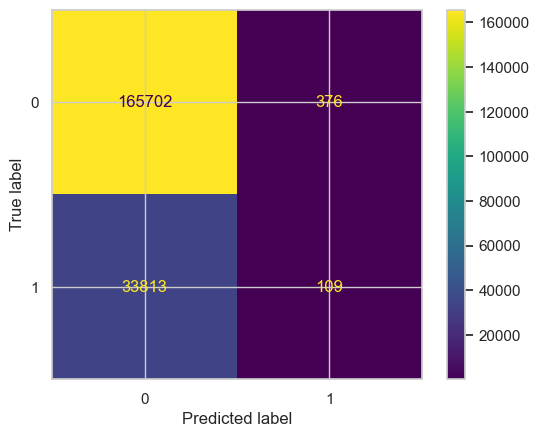


Evaluating Logistic Regression...
Accuracy: 0.829165
Log Loss: 0.43916452850014864
Precision: 0.23194748358862144
Recall: 0.0031248157537881022
F1 Score: 0.00616655516448995
AUC: 0.6272678441745543


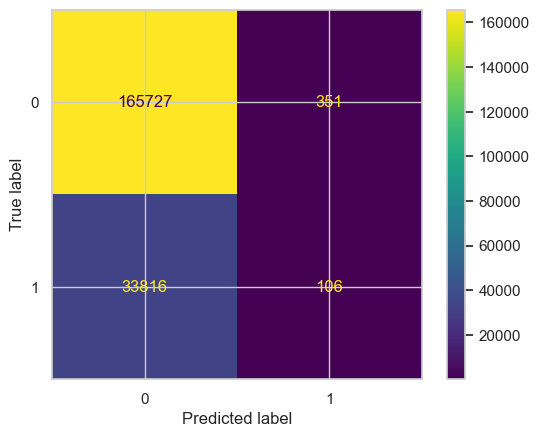

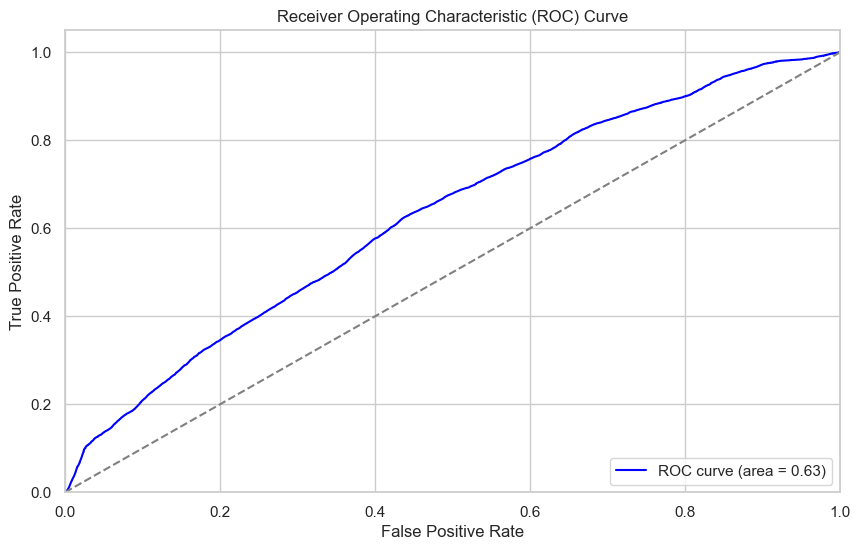


Evaluating XGBoost...
Accuracy: 0.83353
Log Loss: 0.4138594065809691
Precision: 0.594692400482509
Recall: 0.05813336477802016
F1 Score: 0.1059133143563027
AUC: 0.7082679832136033


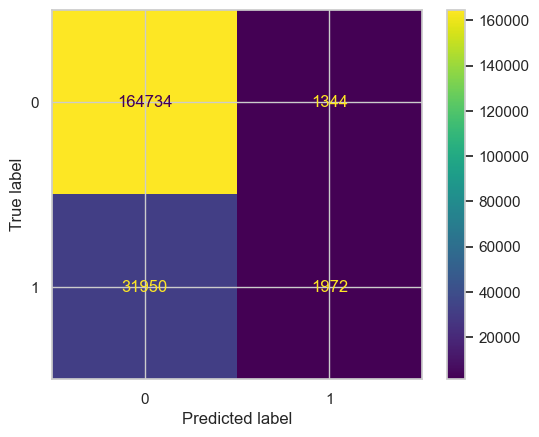

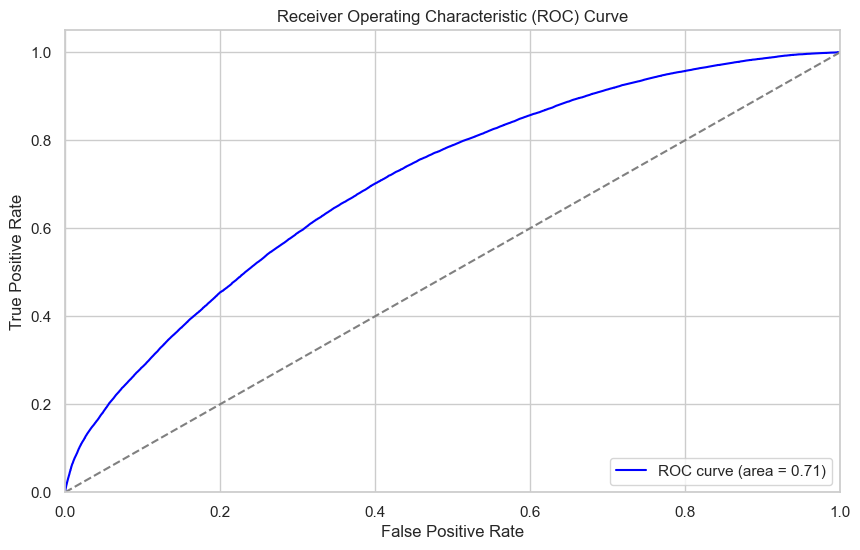

In [23]:
df1 = no_cat_data(df)
X_test_1 = no_cat_data(X_test)
X_train_1 = df1.drop(columns=['click'])
m,p,r=evaluate_models(X_train_1, X_test_1, y_train, y_test)

We see that surprsingly we get a decent logloss of <b>0.4138</b> even though we are losing so much information when dropping all those columns. So this means there is room for improvement if we can incorporate those values from the dropped columns.

# Approach 2

For the second approach, we know that all the columns (except click, week and hour) are categorical so let's target encode them all and see how it perform.

In [24]:
col_names = [col for col in df.columns if col not in ['hour_sin', 'weekday_sin', 'click']]


Evaluating Linear Regression...
Accuracy: 0.81747
Log Loss: None
Precision: 0.2800476676881171
Recall: 0.04849360297152291
F1 Score: 0.08267162528897376
AUC: None


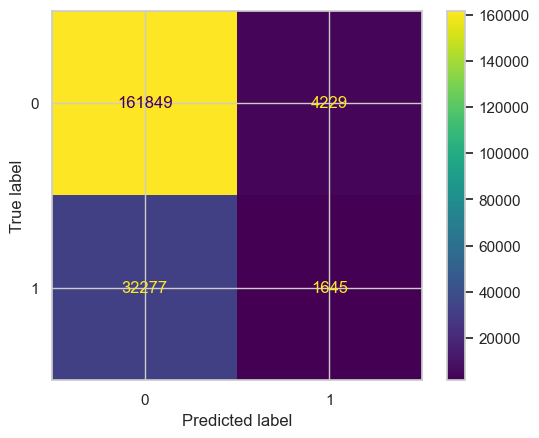


Evaluating Logistic Regression...
Accuracy: 0.81091
Log Loss: 0.5645580979170227
Precision: 0.3054723387257839
Recall: 0.09017746595130004
F1 Score: 0.13924799708667152
AUC: 0.6665110923565536


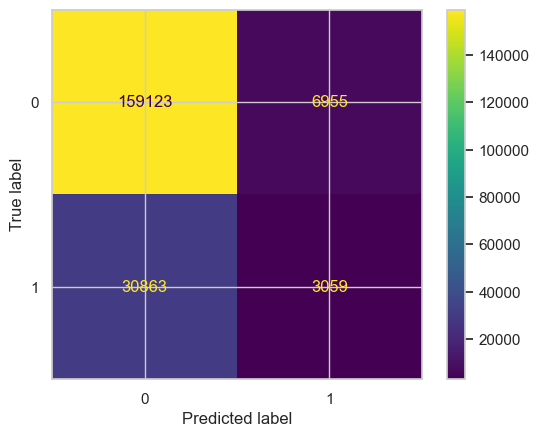

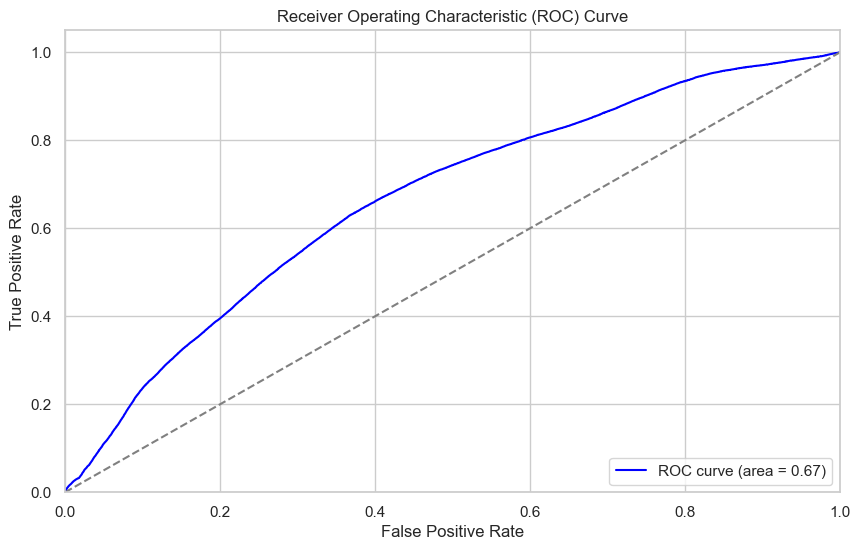


Evaluating XGBoost...
Accuracy: 0.81596
Log Loss: 0.8106823524568069
Precision: 0.3782894736842105
Recall: 0.13221508165792112
F1 Score: 0.1959456507492682
AUC: 0.6614673158843897


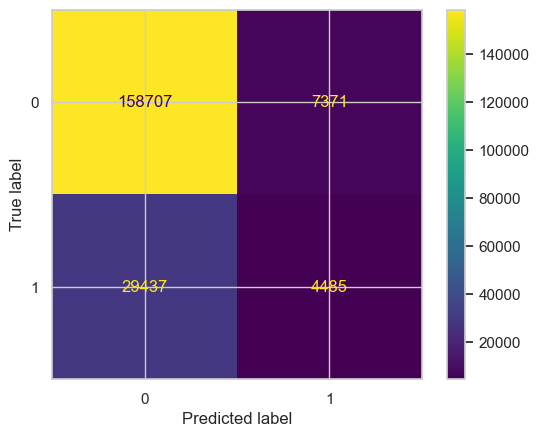

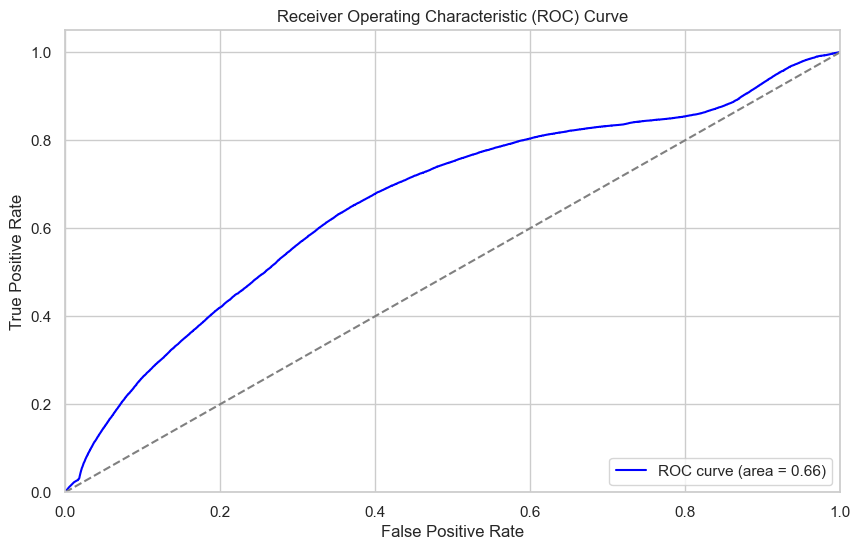

In [25]:
df2, target_categories = all_target_traindata(df,col_names)
X_test_2 = all_target_testdata(X_test,target_categories,col_names,df['click'].mean())
X_train_2 = df2.drop(columns=['click'])
m,p,r = evaluate_models(X_train_2, X_test_2, y_train, y_test)

With a terrible logloss of <b>0.56</b> with logistic, this means that just target encoding everything makes the classification very much worse. Removing the categorical columns was working a lot better. So, we can do some feature engineering to figure out how to handle different columns.

# Approach 3

Another approach we can take is One hot encode all the columns. But this will lead to huge dimesion since some columns have thousands of unique categories. So rather, let's one hot encode those columns which have less than 10 unique columns. Then we will target encode those columns with many categories. For features like device_id and device_ip since they have too many unique values, lets drop them for now and see.

In [26]:
df.nunique()

C1                       7
banner_pos               7
site_id               2529
site_domain           2693
site_category           22
app_id                2898
app_domain             184
app_category            26
device_id           122738
device_ip           463036
device_model          4989
device_type              4
device_conn_type         4
C14                   2194
C15                      8
C16                      9
C17                    418
C18                      4
C19                     66
C20                    163
C21                     60
hour_sin                21
weekday_sin              7
click                    2
dtype: int64

These are the columns with unique categories less than 10 so we one hot encode them using the function we created earlier.

In [27]:
ohe_list = ['C1','banner_pos','device_type','device_conn_type','C15','C16','C18']
df_3, ohe_dict = all_ohe_traindata(df,ohe_list)
X_test_3 = all_ohe_testdata(X_test, ohe_dict, ohe_list)

Now, let us target encode the columns with many categories using the function we created earlier

In [28]:
target_encode_list = ['site_category','app_category','C14','C17','C19','C20','C21','site_id','site_domain','app_id','app_domain','device_model']
df_3, target_dict = all_target_traindata(df_3, target_encode_list)
X_test_3 = all_target_testdata(X_test_3, target_dict, target_encode_list, df['click'].mean())

# Removing rest of object datatypes
X_test_3 = no_cat_data(X_test_3)
df_3 = no_cat_data(df_3)


Evaluating Linear Regression...
Accuracy: 0.83444
Log Loss: None
Precision: 0.5911751463304817
Recall: 0.07741288839101468
F1 Score: 0.13689917631112503
AUC: None


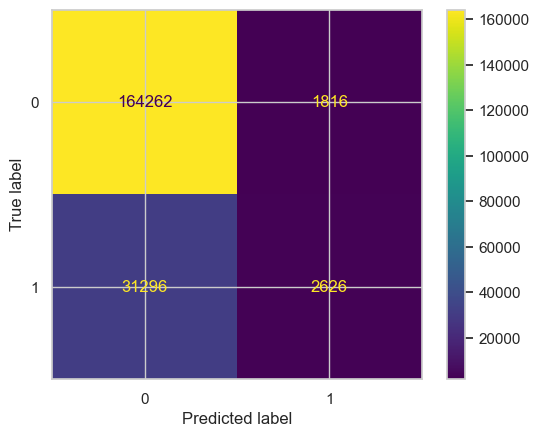


Evaluating Logistic Regression...
Accuracy: 0.83225
Log Loss: 0.4075654333988787
Precision: 0.5242061426340447
Recall: 0.11874299864394788
F1 Score: 0.19362591933855694
AUC: 0.7310944360013498


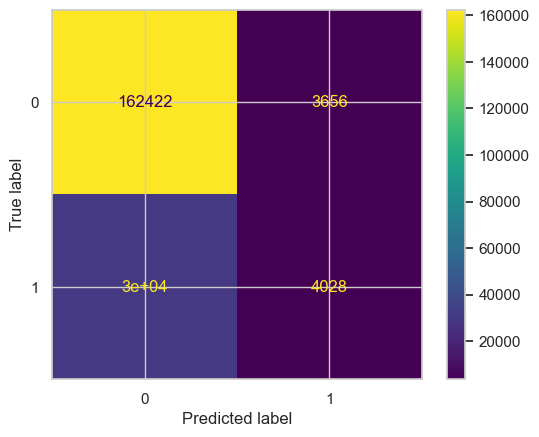

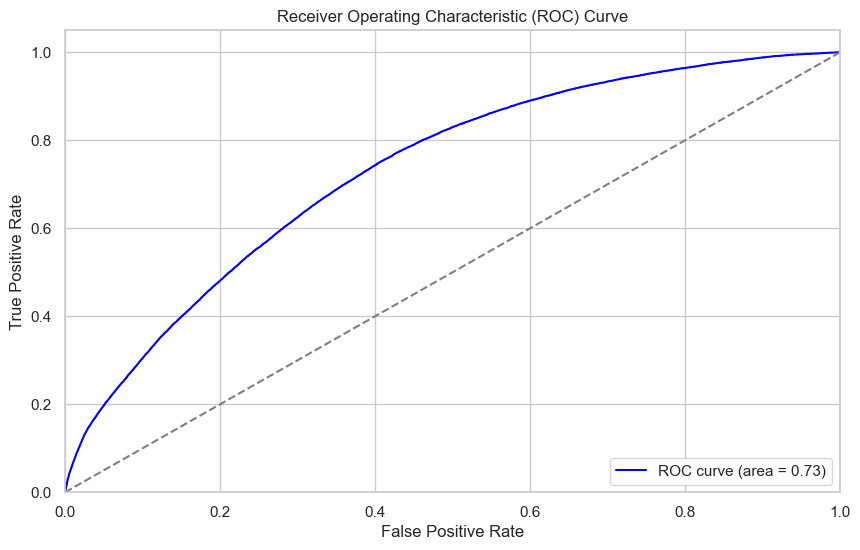


Evaluating XGBoost...
Accuracy: 0.83474
Log Loss: 0.4089764181106197
Precision: 0.5870348139255702
Recall: 0.08649254171334238
F1 Score: 0.15077081192189107
AUC: 0.7420355718980655


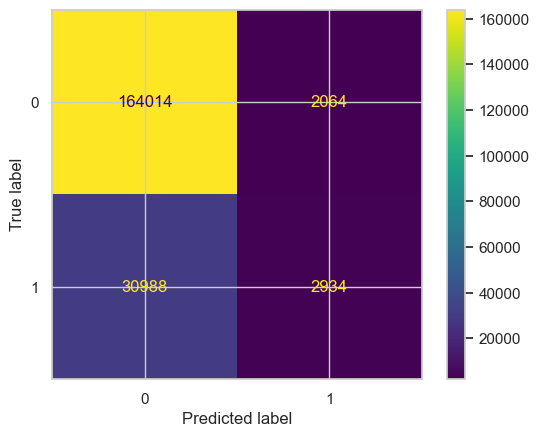

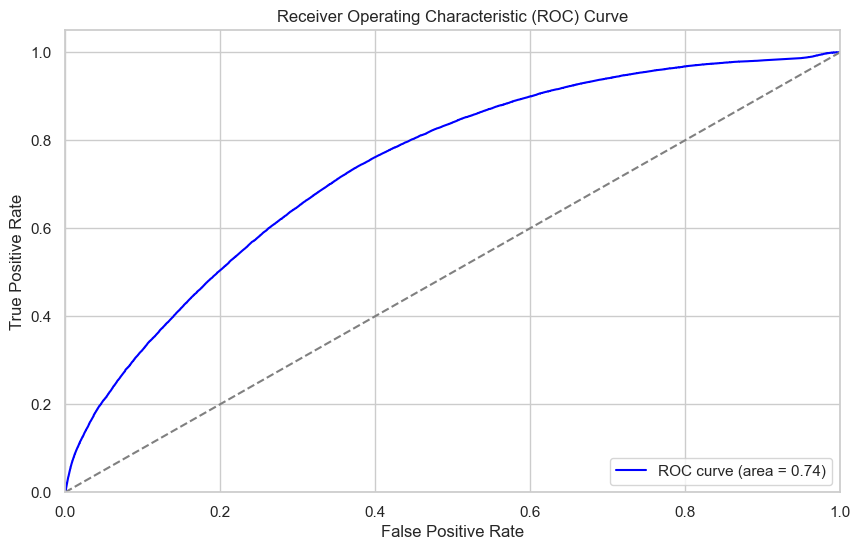

In [29]:
X_train_3 = df_3.drop(columns='click')
m, p, r = evaluate_models(X_train_3, X_test_3, y_train, y_test)

Notice that we have a slightly better model than out first approach with a logloss of <b>0.4090</b> with XGBoost. But still we are dropping some columns and we havent looked at the correlation of data yet!

# Approach 4 : Some More Feature Engineering

Rather than dropping device_id and device_ip, let's see if there is anything interesting we can find out.

This is a function that plots the top 20 categories with highest frequency and how many 0s and 1s are in the click for that column.

In [30]:
def plotter(cols, top_n=20):
    # Create subplots with enough space to fit all the plots
    n_cols = len(cols)
    fig, axes = plt.subplots(1, n_cols, figsize=(n_cols * 10, 6))
    
    # If only one column, axes will not be an array, so convert to array for consistency
    if n_cols == 1:
        axes = [axes]
    
    # Loop through each column to plot
    for i, col in enumerate(cols):
        # Get top N categories for the column
        top_categories = df[col].value_counts().nlargest(top_n).index  # Get top N category names
        filtered_df = df[df[col].isin(top_categories)]  # Filter the dataset
        
        # Plot using seaborn
        sns.countplot(x=col, hue="click", data=filtered_df, order=top_categories, palette="coolwarm", ax=axes[i])
        axes[i].set_xlabel("Category")
        axes[i].set_ylabel("Count")
        axes[i].set_title(f"Top {top_n} Categories with Click Distribution: {col}")
        axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
        
        # Add legend and grid for clarity
        axes[i].legend(title="Click")
        axes[i].grid(True)

    # Adjust the layout for better spacing between subplots
    plt.tight_layout()
    plt.show()

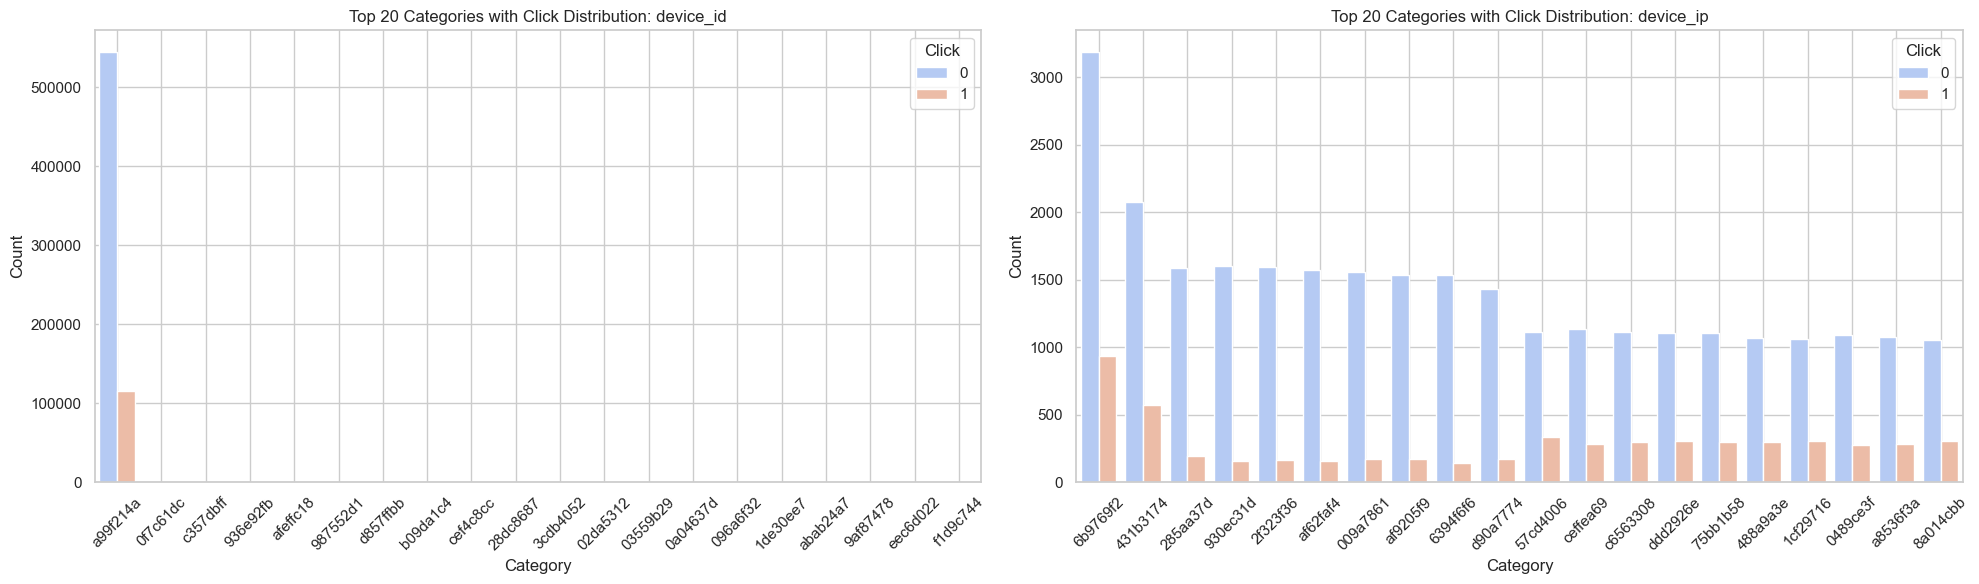

In [31]:
plotter(['device_id', 'device_ip'])

While there is not anything interesting with device_ip, notice that majority of device_id is just one category i.e. 'a99f214a'. So rather than just dropping this column, let's replace it with a column that gives 1 if this category is present and 0 else.

In [32]:
# One hot encoding as previous
df_5, ohe_dict = all_ohe_traindata(df,['C1','banner_pos','device_type','device_conn_type','C15','C16','C18'])
X_test_5 = all_ohe_testdata(X_test, ohe_dict, ['C1','banner_pos','device_type','device_conn_type','C15','C16','C18'])

# Target encoding as previous
target_encode_list = ['site_category','app_category','C14','C17','C19','C20','C21','site_id','site_domain','app_id','app_domain']
df_5, target_dict = all_target_traindata(df_5, target_encode_list)
X_test_5 = all_target_testdata(X_test_5, target_dict, target_encode_list, df['click'].mean())

# Replacing device_id with the occurence of 'a99f214a' instead
df_5['device_id_dominant'] = (df_5['device_id'] == 'a99f214a').astype(int)
# Drop the original 'device_id' column
df_5 = df_5.drop(columns=['device_id'])
X_test_5['device_id_dominant'] = (X_test_5['device_id'] == 'a99f214a').astype(int)
# Drop the original 'device_id' column
X_test_5 = X_test_5.drop(columns=['device_id'])

# Removing rest of object datatypes
X_test_5 = no_cat_data(X_test_5)
df_5 = no_cat_data(df_5)
X_train_5 = df_5.drop(columns='click')

Also lets see the correlation matrix to find if we can drop some columns that will help reduce dimensions.

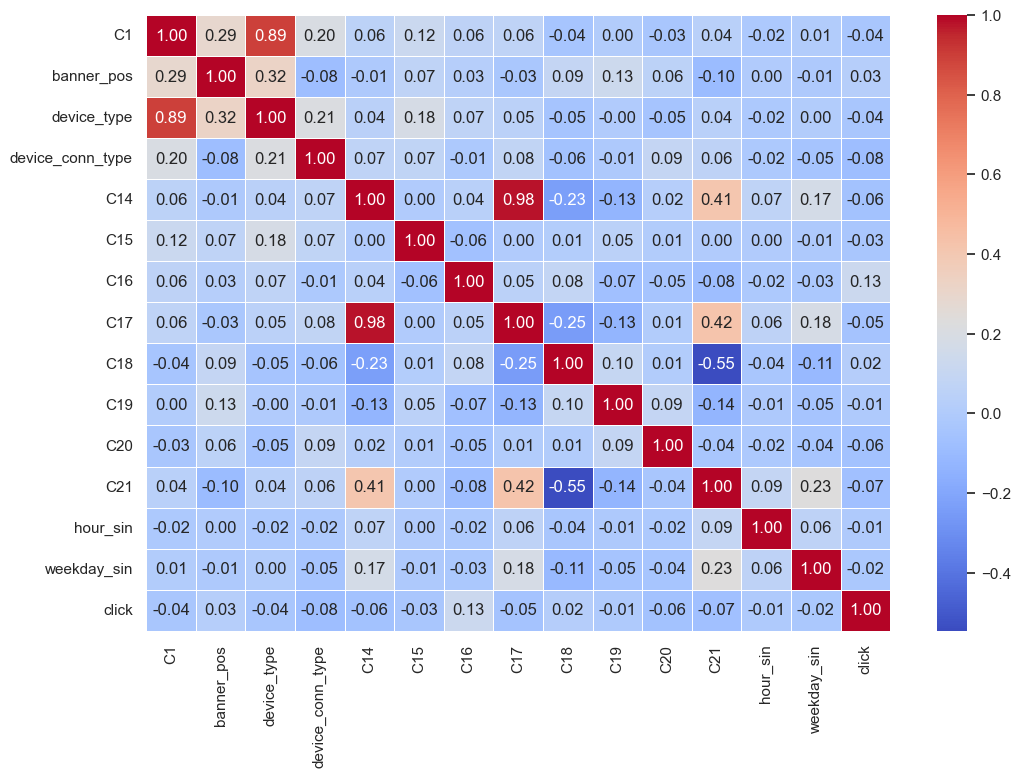

In [33]:
corr_matrix = df.select_dtypes(include = ['number']).corr()

plt.figure(figsize=(12, 8))  # Adjust the figure size
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.show()

We can see that C17 and C14 have a really high correlation of 0.98! 'C17' has 418 unique categories and 'C14' has 2194. Notice we have target encoded them both. It might seem reasonable to keep C14 since we will have more details but since our data is so imbalanced, this can easliy lead to overfitting. Hence a safer and stable choice is to keep C17 and drop C14.</br>

Similarly, 'C1' and 'device_type' has a high correlation of 0.89. 'C1' has 7 unique categories and 'device_type' has 4. Notice we have one hot encoded both columns. So to reduce the dimensions and complexity and avoid sparse values, lets drop 'C1' since it has more categories and keep 'device_type'

In [34]:
X_train_5 = X_train_5.drop(columns='C14')
X_test_5 = X_test_5.drop(columns='C14')
X_train_5 = X_train_5.loc[:, ~X_train_5.columns.str.startswith('C1_')]
X_test_5 = X_test_5.loc[:, ~X_test_5.columns.str.startswith('C1_')]


Evaluating Linear Regression...
Accuracy: 0.834435
Log Loss: None
Precision: 0.5942231539715817
Recall: 0.07520193384824007
F1 Score: 0.13350778490121679
AUC: None


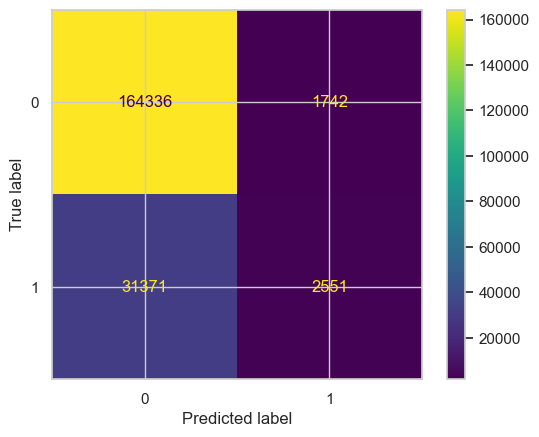


Evaluating Logistic Regression...
Accuracy: 0.832015
Log Loss: 0.40783829642156366
Precision: 0.5201738050900062
Recall: 0.12351866045634102
F1 Score: 0.19963313242966385
AUC: 0.7288024886529965


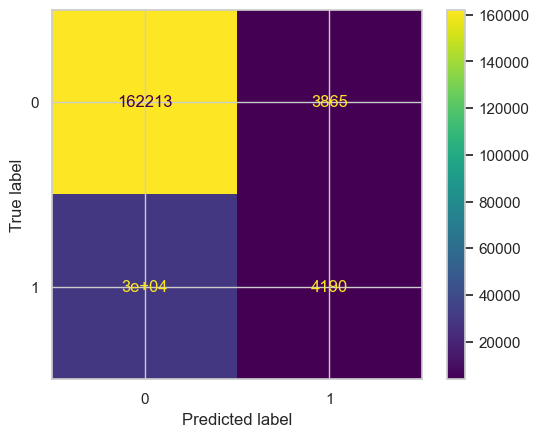

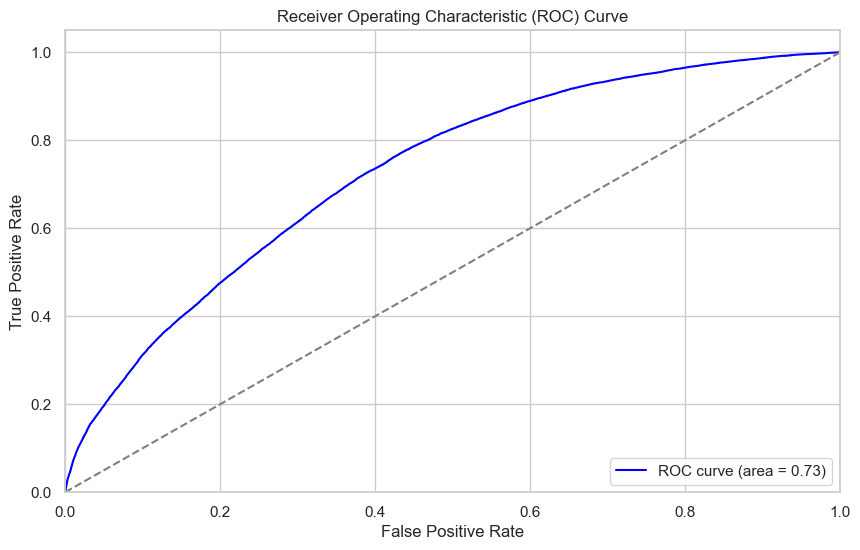


Evaluating XGBoost...
Accuracy: 0.834875
Log Loss: 0.4057235741973333
Precision: 0.5922270203578038
Recall: 0.08490065444254466
F1 Score: 0.1485110223024365
AUC: 0.74136598727421


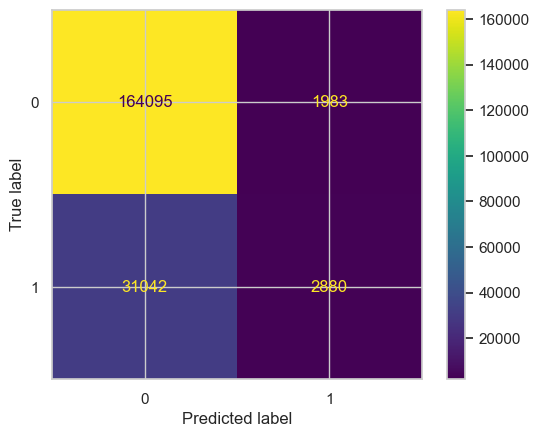

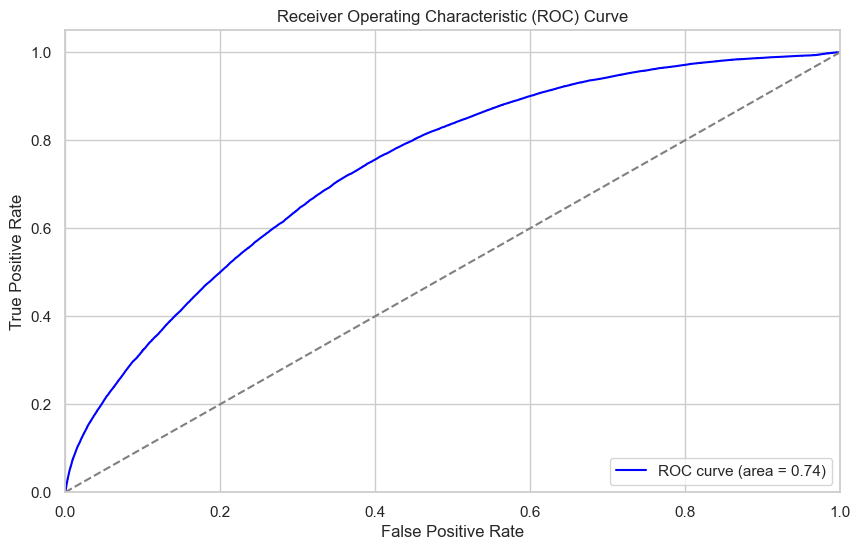

In [35]:
m,p,r = model,processor,_=evaluate_models(X_train_5, X_test_5, y_train, y_test)

We have achieved an improved logloss of <b>0.4057</b> with XGBoost and AUC of 0.7414 with out feature engineering. We will stick to this preprocessing and now improve out machine learning model.

# Choosing and Fine Tuning Model

Among the 3 different ML modedls we tried, Linear Regression was extremely bad which makes sense when we see the correlation heatmap as the correlation of columns with 'click' was really low meaning there was no linear relationship with the label.

Logistic and XGBoost performed really good but XGBoost had a better value by a slight margin.

We currently have a model that gives a logloss of <b>0.4057</b>.So now, we will be fine tuning XGBoost to see if we can improve our model.

Let's create a function that takes the soft probabilities as parameter and gives us the performance metrics like before.

In [36]:
def evaluate_xgboost_model(predictions, y_test, predictions_proba=None):
    
    # Calculate Accuracy
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy: {accuracy:.4f}")

    # Calculate Log Loss (only if probabilities are provided)
    if predictions_proba is not None:
        logloss = log_loss(y_test, predictions_proba)
        print(f"Log Loss: {logloss:.4f}")

    # Calculate Precision
    precision = precision_score(y_test, predictions)
    print(f"Precision: {precision:.4f}")

    # Calculate Recall
    recall = recall_score(y_test, predictions)
    print(f"Recall: {recall:.4f}")

    # Calculate F1 Score
    f1 = f1_score(y_test, predictions)
    print(f"F1 Score: {f1:.4f}")

    # Calculate AUC Score (only if probabilities are provided)
    if predictions_proba is not None:
        auc_score = roc_auc_score(y_test, predictions_proba)
        print(f"AUC Score: {auc_score:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    # ROC Curve (only if probabilities are provided)
    if predictions_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, predictions_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()

# First lets apply bagging to our XGBoost

In [37]:
from sklearn.utils import resample
from sklearn.metrics import log_loss
import numpy as np

# Make sure the features are aligned between train and test sets
X_train_5, X_test_5 = X_train_5.align(X_test_5, join='inner', axis=1)

n_estimators = 10  # Number of models (trees) for bagging
predictions = np.zeros((X_test_5.shape[0], n_estimators))  # Store predictions from each model
log_losses = []  # List to store log loss for each iteration

model = xgb.XGBClassifier(eval_metric='logloss')

for i in range(n_estimators):
    # Resample the training data (bootstrapping)
    X_resampled, y_resampled = resample(X_train_5, y_train, random_state=i)

    # Train the XGBoost model (best_model_3 already contains the best hyperparameters)
    model.fit(X_resampled, y_resampled)

    # Store the predictions from each model (probabilities of class 1)
    predictions[:, i] = model.predict_proba(X_test_5)[:, 1]  # Get probabilities for class 1

    # Calculate and store the log loss for this iteration
    log_loss_value = log_loss(y_test, model.predict_proba(X_test_5)[:, 1])
    log_losses.append(log_loss_value)

    # Print which bagging iteration is being applied and its log loss
    print(f"Applying Bagging Model {i + 1}... Log Loss: {log_loss_value}")

# Average the predictions across all models
final_predictions_prob = np.mean(predictions, axis=1)
final_predictions = (final_predictions_prob >= 0.5).astype(int)  # Convert to 0 or 1

# Optionally, print the overall log loss for the final predictions
final_log_loss = log_loss(y_test, final_predictions_prob)
print(f"Final Log Loss for Averaged Model: {final_log_loss}")

Applying Bagging Model 1... Log Loss: 0.4057330675207472
Applying Bagging Model 2... Log Loss: 0.40621787323731695
Applying Bagging Model 3... Log Loss: 0.4057941284610149
Applying Bagging Model 4... Log Loss: 0.4056546329320872
Applying Bagging Model 5... Log Loss: 0.40578459125881394
Applying Bagging Model 6... Log Loss: 0.4059814265990563
Applying Bagging Model 7... Log Loss: 0.4059422747637223
Applying Bagging Model 8... Log Loss: 0.4060011563175658
Applying Bagging Model 9... Log Loss: 0.4059230904765192
Applying Bagging Model 10... Log Loss: 0.40561259053286847
Final Log Loss for Averaged Model: 0.404169703857941


Accuracy: 0.8351
Log Loss: 0.4042
Precision: 0.5983
Recall: 0.0839
F1 Score: 0.1472
AUC Score: 0.7434


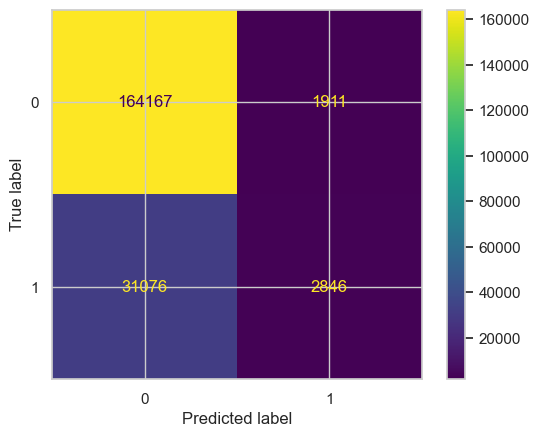

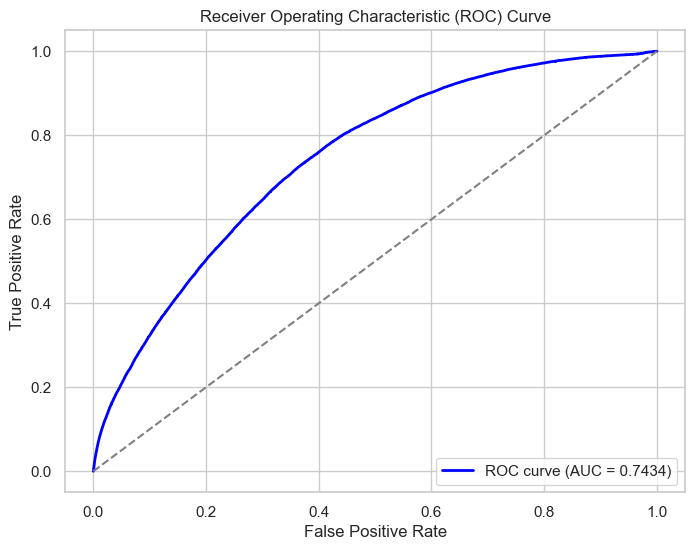

In [38]:
evaluate_xgboost_model(final_predictions, y_test, predictions_proba=final_predictions_prob)

After applying bagging with 10 n_estimators, notie that we have slightly improved the logloss now to <b>0.4042</b> which mean bagging improves our prediction of the data and we will be using this in the end.

XGBoost has many parameters such as max_depth, learning_rate, n_estimators, sub_sample, etc. Running a GridSearchCV on all of them at once is computationally very expensive as it has to try differnt combinations. So instead, we will take 2 parameters at a time and evolve our model. This wont be the optimal but it will be good enough for our purpose.

First, we will try different values of :</br>
<b>max_depth</b>: The maximum depth of a decision tree, controlling the model's complexity and overfitting (larger values increase model complexity).</br>
<b>learning_rate</b> :  The step size used to update the model's weights during training, controlling how fast the model learns (lower values make the model train more slowly but can lead to better performance).

In [39]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [6,9,12],
    'learning_rate': [0.01, 0.5, 0.1, 0.2],
}
# Initialize the XGBoost classifier
model = xgb.XGBClassifier(eval_metric='logloss')

# Initialize GridSearchCV with the model, parameter grid, and cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=4, scoring='neg_log_loss')

# Fit the grid search to the training data
grid_search.fit(X_train_5, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Retrieve the best model based on the grid search
best_model = grid_search.best_estimator_

# Optionally, evaluate the best model
y_pred = best_model.predict(X_test_5)
y_pred_proba = best_model.predict_proba(X_test_5)[:, 1] 

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 9}


Accuracy: 0.8352
Log Loss: 0.4042
Precision: 0.6056
Recall: 0.0816
F1 Score: 0.1438
AUC Score: 0.7429


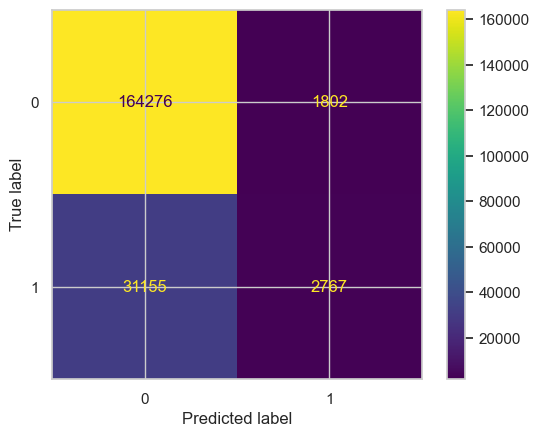

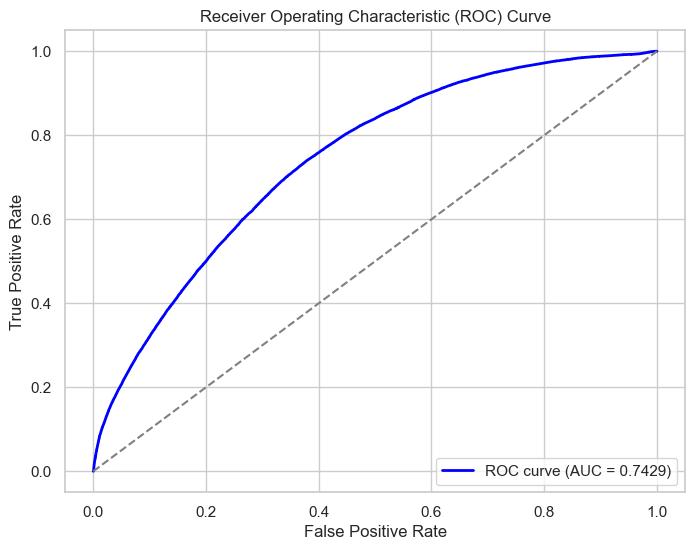

In [40]:
evaluate_xgboost_model(y_pred, y_test, predictions_proba=y_pred_proba)

Choosing this parameter brought down the logloss to <b>0.4042</b>.

Next, we will try different values of :</br>
<b>n_estimators</b>: The number of boosting rounds or trees to build, where more trees can improve performance but may also lead to overfitting if too large.</br>
<b>subsample</b> :  The fraction of training data to randomly sample for each boosting round, used to prevent overfitting (values between 0.5 and 1.0, where lower values can add regularization).

In [41]:
param_grid_2 = {
    'n_estimators': [100, 200],
    'subsample': [0.8, 0.9, 1.0],
}

# Initialize the XGBoost classifier with the best parameters from the first search
model_2 = xgb.XGBClassifier(
    learning_rate=0.1,  # Best learning_rate from previous search
    max_depth=9,        # Best max_depth from previous search
    eval_metric='logloss',
)

# Initialize GridSearchCV with the model, updated parameter grid, and cross-validation
grid_search_2 = GridSearchCV(estimator=model_2, param_grid=param_grid_2, cv=4, scoring='neg_log_loss')

# Fit the grid search to the training data
grid_search_2.fit(X_train_5, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters (with n_estimators and subsample):", grid_search_2.best_params_)

# Retrieve the best model based on the grid search
best_model_2 = grid_search_2.best_estimator_

# Optionally, evaluate the best model
y_pred = best_model_2.predict(X_test_5)
y_pred_proba = best_model_2.predict_proba(X_test_5)[:, 1]

Best Hyperparameters (with n_estimators and subsample): {'n_estimators': 100, 'subsample': 0.9}


Accuracy: 0.8351
Log Loss: 0.4038
Precision: 0.6021
Recall: 0.0812
F1 Score: 0.1431
AUC Score: 0.7432


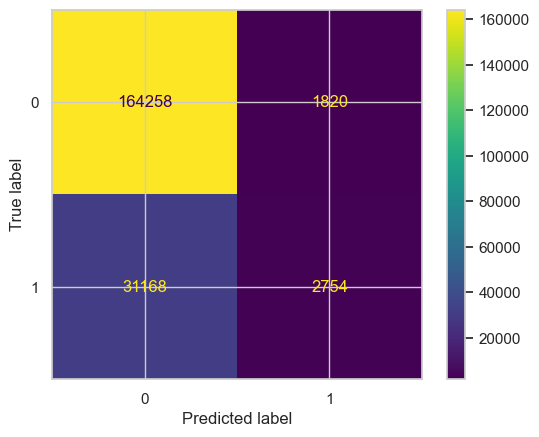

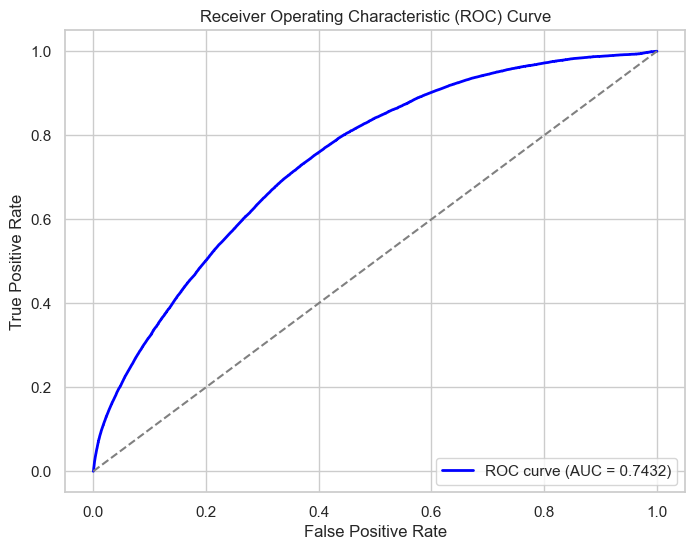

In [42]:
evaluate_xgboost_model(y_pred, y_test, predictions_proba=y_pred_proba)

With these parameters, we have a improved logloss of <b>0.4038</b>

Finally, we will try different values of :</br>
<b>colsample_bytree</b>:The fraction of features (columns) to randomly sample for each tree, helping prevent overfitting (values between 0 and 1).</br>
<b>gamma</b> : The minimum loss reduction required to make a further partition on a leaf node, used as regularization to control the complexity of the model (higher values make the algorithm more conservative).

In [44]:
param_grid_3 = {
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.01, 0.1],
}

# Initialize the XGBoost classifier with the best parameters from the previous search
model_3 = xgb.XGBClassifier(
    learning_rate=0.1,  # Best learning_rate from previous search
    max_depth=9,        # Best max_depth from previous search
    n_estimators=100,   # Best n_estimators from previous search
    subsample=0.9,      # Best subsample from previous search
    eval_metric='logloss',
)

# Initialize GridSearchCV with the model, updated parameter grid, and cross-validation
grid_search_3 = GridSearchCV(estimator=model_3, param_grid=param_grid_3, cv=4, scoring='neg_log_loss')

# Fit the grid search to the training data
grid_search_3.fit(X_train_5, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters (with colsample_bytree and gamma):", grid_search_3.best_params_)

# Retrieve the best model based on the grid search
best_model_3 = grid_search_3.best_estimator_

# Optionally, evaluate the best model
y_pred_3 = best_model_3.predict(X_test_5)
y_pred_proba_3 = best_model_3.predict_proba(X_test_5)[:, 1]

Best Hyperparameters (with colsample_bytree and gamma): {'colsample_bytree': 0.7, 'gamma': 0}


Accuracy: 0.8351
Log Loss: 0.4032
Precision: 0.6037
Recall: 0.0806
F1 Score: 0.1422
AUC Score: 0.7431


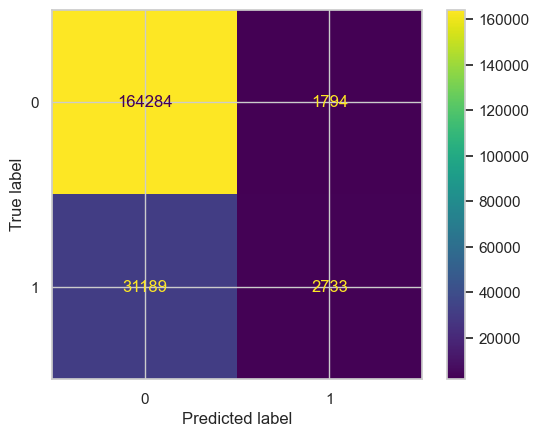

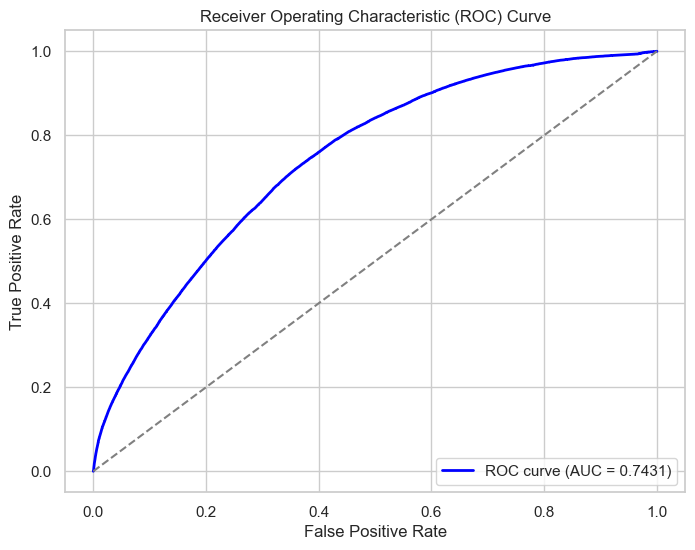

In [60]:
evaluate_xgboost_model(y_pred_3, y_test, predictions_proba=y_pred_proba_3)

With these parameters, we now have a even better model with logloss of <b>0.4032</b>. So lets count this as the final model.

Finally we apply bagging of 20 rounds to our best model to get our final performance metrics.

In [46]:
n_estimators = 20  # Number of models (trees) for bagging
predictions = np.zeros((X_test_5.shape[0], n_estimators))  # Store predictions from each model
log_losses = []  # List to store log loss for each iteration

# Using the best model from grid search
model = best_model_3  # This will use the best hyperparameters from previous search

for i in range(n_estimators):
    # Resample the training data (bootstrapping)
    X_resampled, y_resampled = resample(X_train_5, y_train, random_state=i)

    # Train the XGBoost model (best_model_3 already contains the best hyperparameters)
    model.fit(X_resampled, y_resampled)

    # Store the predictions from each model (probabilities of class 1)
    predictions[:, i] = model.predict_proba(X_test_5)[:, 1]  # Get probabilities for class 1

    # Calculate and store the log loss for this iteration
    log_loss_value = log_loss(y_test, model.predict_proba(X_test_5)[:, 1])
    log_losses.append(log_loss_value)

    # Print which bagging iteration is being applied and its log loss
    print(f"Applying Bagging Model {i + 1}... Log Loss: {log_loss_value}")

# Average the predictions across all models
final_predictions_prob = np.mean(predictions, axis=1)
final_predictions = (final_predictions_prob >= 0.5).astype(int)  # Convert to 0 or 1

# Optionally, print the overall log loss for the final predictions
final_log_loss = log_loss(y_test, final_predictions_prob)
print(f"Final Log Loss for Averaged Model: {final_log_loss}")

Applying Bagging Model 1... Log Loss: 0.404179925688697
Applying Bagging Model 2... Log Loss: 0.4040009153728595
Applying Bagging Model 3... Log Loss: 0.4038783248859591
Applying Bagging Model 4... Log Loss: 0.4039284534639765
Applying Bagging Model 5... Log Loss: 0.4039519020581788
Applying Bagging Model 6... Log Loss: 0.40399551268151745
Applying Bagging Model 7... Log Loss: 0.4038450994981018
Applying Bagging Model 8... Log Loss: 0.403959577815274
Applying Bagging Model 9... Log Loss: 0.4037943461287793
Applying Bagging Model 10... Log Loss: 0.4037510393606555
Applying Bagging Model 11... Log Loss: 0.40405511819628975
Applying Bagging Model 12... Log Loss: 0.4039852772024768
Applying Bagging Model 13... Log Loss: 0.40373423475038
Applying Bagging Model 14... Log Loss: 0.40407615977483174
Applying Bagging Model 15... Log Loss: 0.4037398670501557
Applying Bagging Model 16... Log Loss: 0.4039822939211083
Applying Bagging Model 17... Log Loss: 0.4040118844164059
Applying Bagging Model 1

Accuracy: 0.8352
Log Loss: 0.4029
Precision: 0.6074
Recall: 0.0804
F1 Score: 0.1419
AUC Score: 0.7435


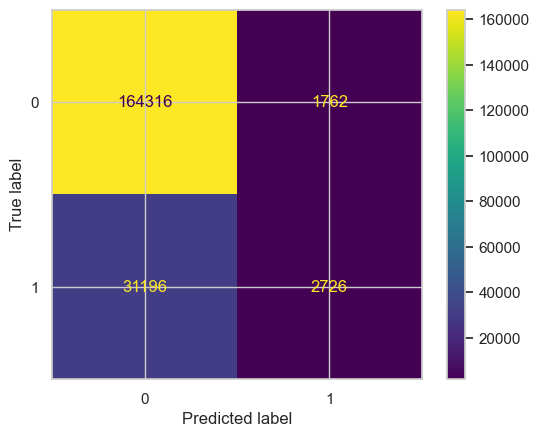

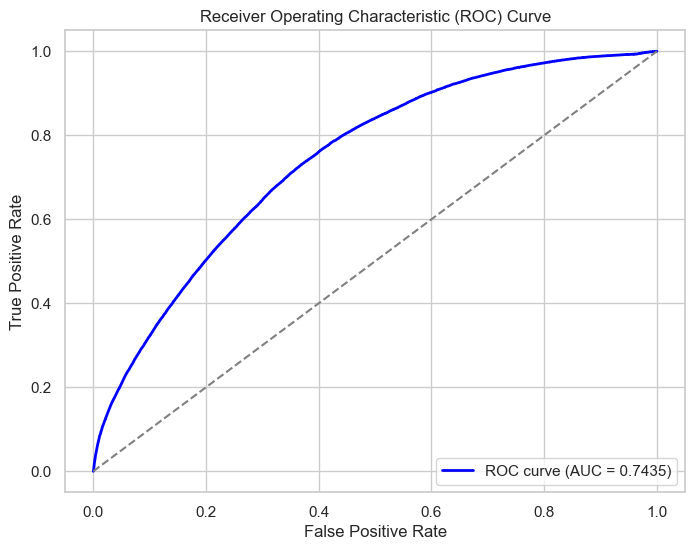

In [47]:
evaluate_xgboost_model(final_predictions, y_test, predictions_proba=final_predictions_prob)

Finally, by fine tuning our model, we were able to get the logloss down from 0.4057 to <b>0.4029</b>.

# Final LogLoss : 0.4029
# Final AUC : 0.7435

# For Kaggel Submission

In [48]:
file_path = r'C:\Users\sthap\Downloads\test\test.csv'

# Import the CSV file into a DataFrame
df_kaggel = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
df_kaggel.head()

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000017e+19,14103100,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,...,1,0,8330,320,50,761,3,175,100075,23
1,1.000018e+19,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,22676,320,50,2616,0,35,100083,51
2,1.000055e+19,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,22676,320,50,2616,0,35,100083,51
3,1.000109e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,0f2161f8,...,1,0,18648,320,50,1092,3,809,100156,61
4,1.000138e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,...,1,0,23160,320,50,2667,0,47,-1,221


# Process the data same way we do to our optimal model

In [49]:
kaggel=df_kaggel.copy()

kaggel['hour_sin'] = kaggel['hour'].apply(lambda x: np.sin(2 * np.pi * datesplit(x).hour / 24))
kaggel['weekday_sin'] = kaggel['hour'].apply(lambda x: np.sin(2 * np.pi * datesplit(x).weekday() / 7))
kaggel = kaggel.drop(columns=['hour'])
kaggel = kaggel.drop(columns=['id'])

In [50]:
kaggel = all_ohe_testdata(kaggel, ohe_dict, ['C1','banner_pos','device_type','device_conn_type','C15','C16','C18'])
kaggel = all_target_testdata(kaggel, target_dict, target_encode_list, df['click'].mean())
kaggel['device_id_dominant'] = (kaggel['device_id'] == 'a99f214a').astype(int)
# Drop the original 'device_id' column
kaggel = kaggel.drop(columns=['device_id'])

kaggel = no_cat_data(kaggel)

In [51]:
kaggel = kaggel.drop(columns='C14')
kaggel = kaggel.loc[:, ~kaggel.columns.str.startswith('C1_')]

# Apply the model of XGboost with 10 bagging rounds

In [52]:
n_estimators = 10
predictions = np.zeros((kaggel.shape[0], n_estimators))
kaggel, X_train_5 = kaggel.align(X_train_5, join='inner', axis=1)
# List to store log loss (if you had a target for evaluation, but here we focus on predictions)
log_losses = []

# Using the best model from grid search (best_model_3)
model = best_model_3

for i in range(n_estimators):
    # Resample the training data (bootstrapping)
    X_resampled, y_resampled = resample(X_train_5, y_train, random_state=i)

    # Train the XGBoost model (best_model_3 already contains the best hyperparameters)
    model.fit(X_resampled, y_resampled)

    # Store the predictions from each model (probabilities of class 1)
    predictions[:, i] = model.predict_proba(kaggel)[:, 1]  # Get probabilities for class 1
    
    # Print the iteration
    print(f"Applying Bagging Model {i + 1}...")

# Average the predictions across all models
final_predictions_prob = np.mean(predictions, axis=1)

Applying Bagging Model 1...
Applying Bagging Model 2...
Applying Bagging Model 3...
Applying Bagging Model 4...
Applying Bagging Model 5...
Applying Bagging Model 6...
Applying Bagging Model 7...
Applying Bagging Model 8...
Applying Bagging Model 9...
Applying Bagging Model 10...


In [53]:
final_predictions_prob

array([0.14369114, 0.22096933, 0.22096933, ..., 0.40982476, 0.03684667,
       0.21499046])

In [54]:
str_kaggle = pd.read_csv(file_path, dtype={'id': str})

# Create the submission format

In [55]:
results_df = pd.DataFrame({
    'id': str_kaggle['id'],
    'click': final_predictions_prob
})

In [56]:
results_df

,id,click
0,10000174058809263569,0.143691
1,10000182526920855428,0.220969
2,10000554139829213984,0.220969
3,10001094637809798845,0.067287
4,10001377041558670745,0.270873
...,...,...
4577459,9998166651591969718,0.409416
4577460,9998249812366450951,0.214990
4577461,99988023653614546,0.409825
4577462,9999086574712596585,0.036847


In [57]:
results_df.to_csv('final_predictions.csv', index=False)

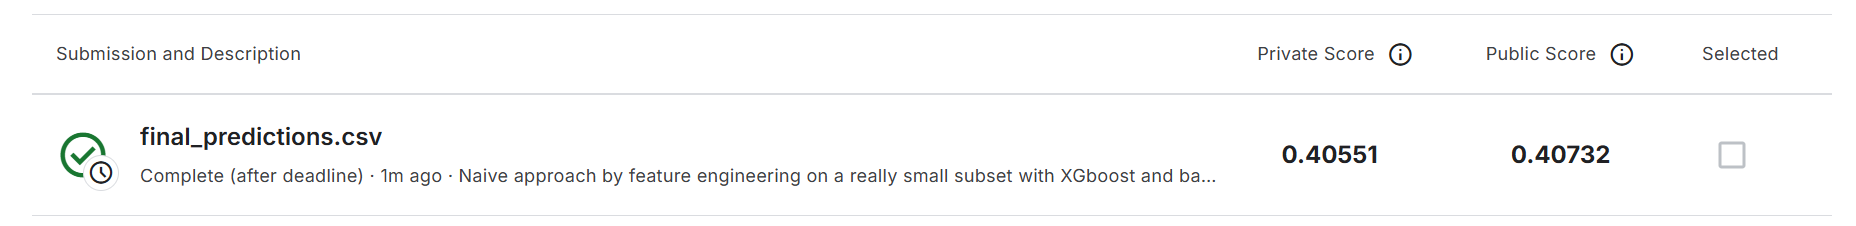

In [58]:
from IPython.display import Image

# Provide the path to the image file
Image(filename=r'C:\Users\sthap\Downloads\Kaggel_Score.jpg')

After submission, it obtained a score of 0.40551 which is surprisingly good considering we only trained on a really small subset of a 6gb dataset. The highest scorer uses Factorization Machines meanwhile to get to the level of 0.38.